In [ ]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio\
    pypdf\
    unstructured\
    pdfminer\
    rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 104.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 15.8 

In [ ]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_together import ChatTogether
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal, List, Dict, Iterable, TypedDict
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.messages import HumanMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import PyPDFLoader
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
import pdfminer
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
import torch
from langchain_core.documents.base import Document
from langchain_core.runnables import RunnableGenerator
from langchain_core.messages.base import BaseMessage
from langgraph.graph import StateGraph, END

In [ ]:
os.environ["TAVILY_API_KEY"] = ""
os.environ["TOGETHER_API_KEY"] = ""

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Part I: Loading pdfs and chunking docs

In [ ]:
def extract_all_links(given_url:str) -> list[str]:
    """
        This code will get an specify URL and then extract all pdf links correspond to only chapters

        Parameters:
        -------------------------------------------------------
        URL: a string contain url link
        Output: A list of chapters correspond to the given link
    """
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        links = soup.find_all("a")
        pdf_links = [link.get('href') for link in links if link.get('href') and link.get('href').endswith('.pdf') and re.match(r'^\d', link.get('href'))]
        full_pdf_links = [urljoin(url, pdf_link) for pdf_link in pdf_links]
        return full_pdf_links
    else:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return None

In [ ]:
url = "https://stanford.edu/~jurafsky/slp3/"
pdf_links = extract_all_links(given_url=url)
pdf_links

['https://stanford.edu/~jurafsky/slp3/2.pdf',
 'https://stanford.edu/~jurafsky/slp3/3.pdf',
 'https://stanford.edu/~jurafsky/slp3/4.pdf',
 'https://stanford.edu/~jurafsky/slp3/5.pdf',
 'https://stanford.edu/~jurafsky/slp3/6.pdf',
 'https://stanford.edu/~jurafsky/slp3/7.pdf',
 'https://stanford.edu/~jurafsky/slp3/8.pdf',
 'https://stanford.edu/~jurafsky/slp3/9.pdf',
 'https://stanford.edu/~jurafsky/slp3/10.pdf',
 'https://stanford.edu/~jurafsky/slp3/11.pdf',
 'https://stanford.edu/~jurafsky/slp3/13.pdf',
 'https://stanford.edu/~jurafsky/slp3/14.pdf',
 'https://stanford.edu/~jurafsky/slp3/15.pdf',
 'https://stanford.edu/~jurafsky/slp3/16.pdf',
 'https://stanford.edu/~jurafsky/slp3/17.pdf',
 'https://stanford.edu/~jurafsky/slp3/18.pdf',
 'https://stanford.edu/~jurafsky/slp3/19.pdf',
 'https://stanford.edu/~jurafsky/slp3/20.pdf',
 'https://stanford.edu/~jurafsky/slp3/21.pdf',
 'https://stanford.edu/~jurafsky/slp3/22.pdf',
 'https://stanford.edu/~jurafsky/slp3/23.pdf']

In [ ]:
def load_pdfs_from_urls(pdf_links: list[str]) -> list[list[PyPDFLoader]]:
    """
    Since we can not load all the urls at once, this function will simply will load each pdf for url seperatably.
    Parameters:
    ----------------------------
    pdf_links: links for each pdf
    output: List of loaded data
    """
    documents = []
    for url in pdf_links:
        loader = PyPDFLoader(url)
        documents.append(loader.load())
    return documents

In [ ]:
documents = load_pdfs_from_urls(pdf_links=pdf_links)

In [ ]:
print(f'The number of loaded chapters are: {len(documents)}\n')
print(f'First chapter which is Regular Expression content:\n{documents[0][0].page_content}')

The number of loaded chapters are: 21

First chapter which is Regular Expression content:
Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright ©2023. All
rights reserved. Draft of February 3, 2024.
CHAPTER
2Regular Expressions, Text
Normalization, Edit Distance
User: I am unhappy.
ELIZA: DO YOU THINK COMING HERE WILL HELP YOU NOT TO BE UNHAPPY
User: I need some help, that much seems certain.
ELIZA: WHAT WOULD IT MEAN TO YOU IF YOU GOT SOME HELP
User: Perhaps I could learn to get along with my mother.
ELIZA: TELL ME MORE ABOUT YOUR FAMILY
User: My mother takes care of me.
ELIZA: WHO ELSE IN YOU FAMILY TAKES CARE OF YOU
User: My father.
ELIZA: YOUR FATHER
User: You are like my father in some ways.
Weizenbaum (1966)
The dialogue above is from ELIZA , an early natural language processing system ELIZA
that could carry on a limited conversation with a user by imitating the responses of
a Rogerian psychotherapist (Weizenbaum, 1966). ELIZA is a surprisingly simple
progr

## Create an object of recursive character text spiliter

In [ ]:
chunk_size = 1024
chunk_overlap = 64
text_splitter = RecursiveCharacterTextSplitter(
  length_function=len,
  chunk_size=chunk_size,
  chunk_overlap=chunk_overlap
)

In [ ]:
pages = 0
for doc in documents:
  pages += len(doc)
pages

568

## Totaly we have 568 pages we must extend all pages into single doc :)

In [ ]:
extended_docs = []
for chapter in documents:
  for page in chapter:
    extended_docs.append(page)

In [ ]:
print(f'Number of pages are: {len(extended_docs)}')
print(f'The first page belongs to fisrt chapter: {extended_docs[0]}')

Number of pages are: 568
The first page belongs to fisrt chapter: page_content='Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright ©2023. All
rights reserved. Draft of February 3, 2024.
CHAPTER
2Regular Expressions, Text
Normalization, Edit Distance
User: I am unhappy.
ELIZA: DO YOU THINK COMING HERE WILL HELP YOU NOT TO BE UNHAPPY
User: I need some help, that much seems certain.
ELIZA: WHAT WOULD IT MEAN TO YOU IF YOU GOT SOME HELP
User: Perhaps I could learn to get along with my mother.
ELIZA: TELL ME MORE ABOUT YOUR FAMILY
User: My mother takes care of me.
ELIZA: WHO ELSE IN YOU FAMILY TAKES CARE OF YOU
User: My father.
ELIZA: YOUR FATHER
User: You are like my father in some ways.
Weizenbaum (1966)
The dialogue above is from ELIZA , an early natural language processing system ELIZA
that could carry on a limited conversation with a user by imitating the responses of
a Rogerian psychotherapist (Weizenbaum, 1966). ELIZA is a surprisingly simple
program that us

## Create chunks

In [ ]:
chunks = text_splitter.split_documents(extended_docs)

In [ ]:
print(len(chunks))

1984


In [ ]:
chunks[0]

Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/2.pdf', 'page': 0}, page_content='Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright ©2023. All\nrights reserved. Draft of February 3, 2024.\nCHAPTER\n2Regular Expressions, Text\nNormalization, Edit Distance\nUser: I am unhappy.\nELIZA: DO YOU THINK COMING HERE WILL HELP YOU NOT TO BE UNHAPPY\nUser: I need some help, that much seems certain.\nELIZA: WHAT WOULD IT MEAN TO YOU IF YOU GOT SOME HELP\nUser: Perhaps I could learn to get along with my mother.\nELIZA: TELL ME MORE ABOUT YOUR FAMILY\nUser: My mother takes care of me.\nELIZA: WHO ELSE IN YOU FAMILY TAKES CARE OF YOU\nUser: My father.\nELIZA: YOUR FATHER\nUser: You are like my father in some ways.\nWeizenbaum (1966)\nThe dialogue above is from ELIZA , an early natural language processing system ELIZA\nthat could carry on a limited conversation with a user by imitating the responses of\na Rogerian psychotherapist (Weizenbaum, 1966). ELIZA i

## Any overlap occurs?

In [ ]:
for index in range(len(chunks)-1):
  if len(chunks[index].page_content) > chunk_size:
    print(chunks[index])
    print("-----------")
    print(len(chunks[index].page_content))
    print("-----------")
    print(chunks[index + 1])
    print("-----------")
    break

# Part II creating embedding

In [ ]:
embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True, model_kwargs={"device": device})
store = LocalFileStore("./cache/")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print(embedding_function)
print(type(embedding_function))

client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
) model_name='sentence-transformers/all-mpnet-base-v2' cache_folder=None model_kwargs={'device': device(type='cuda')} encode_kwargs={} multi_process=True show_progress=True
<class 'langchain_community.embeddings.huggingface.HuggingFaceEmbeddings'>


In [ ]:
namespace = str(embedding_function.model_name)
namespace

'sentence-transformers/all-mpnet-base-v2'

In [ ]:
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    embedding_function, store, namespace=namespace
)

# Part III Vector store or retrieve

In [ ]:
bm25_retriever = BM25Retriever.from_documents(
    documents=chunks,
)
bm25_retriever.k = 2

In [ ]:
faiss_vectorstore = FAISS.from_documents(
    documents=chunks,
    embedding=cached_embedder
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})

In [ ]:
ensemble_retriever_1 = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)

In [ ]:
ensemble_retriever_2 = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.4, 0.6]
)

In [ ]:
ensemble_retriever_3 = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.6, 0.4]
)

In [ ]:
ensemble_retriever_1.get_relevant_documents("properties of human conversation")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/15.pdf', 'page': 19}, page_content='on real users.\nBibliographical and Historical Notes\nThe linguistic, philosophical, and psychological literature on dialogue is quite ex-\ntensive. For example the idea that utterances in a conversation are a kind of action\nbeing performed by the speaker was due originally to the philosopher Wittgenstein\n(1953) but worked out more fully by Austin (1962) and his student John Searle.\nVarious sets of speech acts have been deﬁned over the years, and a rich linguistic\nand philosophical literature developed, especially focused on explaining the use of\nindirect speech acts. The idea of dialogue acts draws also from a number of other\nsources, including the ideas of adjacency pairs, pre-sequences, and other aspects of\nthe interactional properties of human conversation developed in the ﬁeld of conver-\nsation analysis (see Levinson (1983) for an introduction to the ﬁeld). This idea that

In [ ]:
ensemble_retriever_2.get_relevant_documents("properties of human conversation")

[Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/15.pdf', 'page': 0}, page_content='Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright ©2023. All\nrights reserved. Draft of February 3, 2024.\nCHAPTER\n15Chatbots & Dialogue Systems\nLes lois de la conversation sont en g ´en´eral de ne s’y appesantir sur aucun ob-\njet, mais de passer l ´eg`erement, sans effort et sans affectation, d’un sujet `a un\nautre ; de savoir y parler de choses frivoles comme de choses s ´erieuses\n[The rules of conversation are, in general, not to dwell on any one subject,\nbut to pass lightly from one to another without effort and without affectation;\nto know how to speak about trivial topics as well as serious ones;]\nThe 18th C. Encyclopedia of Diderot, start of the entry on conversation\nThe literature of the fantastic abounds in inanimate objects magically endowed with\nthe gift of speech. From Ovid’s statue of Pygmalion to Mary Shelley’s story about\nFrankenstei

In [ ]:
ensemble_retriever_3.get_relevant_documents("properties of human conversation")

[Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/15.pdf', 'page': 19}, page_content='on real users.\nBibliographical and Historical Notes\nThe linguistic, philosophical, and psychological literature on dialogue is quite ex-\ntensive. For example the idea that utterances in a conversation are a kind of action\nbeing performed by the speaker was due originally to the philosopher Wittgenstein\n(1953) but worked out more fully by Austin (1962) and his student John Searle.\nVarious sets of speech acts have been deﬁned over the years, and a rich linguistic\nand philosophical literature developed, especially focused on explaining the use of\nindirect speech acts. The idea of dialogue acts draws also from a number of other\nsources, including the ideas of adjacency pairs, pre-sequences, and other aspects of\nthe interactional properties of human conversation developed in the ﬁeld of conver-\nsation analysis (see Levinson (1983) for an introduction to the ﬁeld). This idea that

In [ ]:
retriever = ensemble_retriever_2

## One example for NLP for retriever

In [ ]:
retriever.get_relevant_documents("Speech acts in chatbots")

[Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/15.pdf', 'page': 18}, page_content='help protect the safety of experimental subjects.\n15.6 Summary\nChatbots anddialogue systems are crucial speech and language processing appli-\ncations that are already widely used commercially.\n• In human dialogue, speaking is a kind of action; these acts are referred to\nas speech acts or dialogue acts. Speakers also attempt to achieve common\nground by acknowledging that they have understand each other. Conversation\nalso is characterized by turn structure and dialogue structure.\n• Chatbots are conversational systems designed to mimic the appearance of in-\nformal human conversation. Rule-based chatbots like ELIZA and its modern'),
 Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/15.pdf', 'page': 25}, page_content='26 Chapter 15 • Chatbots & Dialogue Systems\nWilliams, J. D. and S. J. Young. 2007. Partially observ-\nable markov decision processes for spoken dia

## One example for Computer Science

In [ ]:
retriever.get_relevant_documents("Binary Search Tree(BST)")

[Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/18.pdf', 'page': 17}, page_content='18 CHAPTER 18 • D EPENDENCY PARSING\nfunction MAXSPANNING TREE(G=(V ,E) ,root,score )returns spanning tree\nF←[]\nT’←[]\nscore’←[]\nfor each v∈Vdo\nbestInEdge←argmaxe=(u,v)∈Escore[e]\nF←F∪bestInEdge\nfor each e=(u,v)∈Edo\nscore’[e]←score[e]−score[bestInEdge]\nifT=(V ,F) is a spanning tree then return it\nelse\nC←a cycle in F\nG’←CONTRACT (G,C)\nT’←MAXSPANNING TREE(G’,root,score’ )\nT←EXPAND (T’,C)\nreturn T\nfunction CONTRACT (G,C)returns contracted graph\nfunction EXPAND (T,C)returns expanded graph\nFigure 18.12 The Chu-Liu Edmonds algorithm for ﬁnding a maximum spanning tree in a\nweighted directed graph.\nOn arbitrary directed graphs, this version of the CLE algorithm runs in O(mn)\ntime, where mis the number of edges and nis the number of nodes. Since this par-\nticular application of the algorithm begins by constructing a fully connected graph\nm=n2yielding a running time of O(n3

## One example out of context

In [ ]:
retriever.get_relevant_documents("Who is the president of Bolivia country?")

[Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/3.pdf', 'page': 18}, page_content='COCA is a balanced corpus, meaning that it has roughly equal numbers of words\nfrom different genres: web, newspapers, spoken conversation transcripts, ﬁction,\nand so on, drawn from the period 1990-2019, and has the context of each n-gram as\nwell as labels for genre and provenance.\nSome example 4-grams from the Google Web corpus:\n4-gram Count\nserve as the incoming 92\nserve as the incubator 99\nserve as the independent 794\nserve as the index 223\nserve as the indication 72\nserve as the indicator 120\nserve as the indicators 45\nEfﬁciency considerations are important when building language models that use\nsuch large sets of n-grams. Rather than store each word as a string, it is generally\nrepresented in memory as a 64-bit hash number, with the words themselves stored\non disk. Probabilities are generally quantized using only 4-8 bits (instead of 8-byte\nﬂoats), and n-grams are 

# Chain implementing

In [ ]:
llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0
    )

In [ ]:
router_prompt_template = (
    "You are an expert in routing user queries to either a VectorStore, SearchEngine, or a Fallback Message.\n"
    "Your VectorStore contains data specifically about natural language processing (NLP). If the given query is about NLP or contains data related to NLP, choose VectorStore.\n"
    "If the query is not about NLP but is related to computer science or contains data about computer science, choose SearchEngine.\n"
    "If the query does not contain any data about NLP or computer science, do not choose any tool and return the string None.\n"
    "Give me only and only the name of the tool you chose and nothing more. If there are no chosen tools, give me back the string None.\n"
    "{output_instructions}\n"
    "query: {query}"
)

In [ ]:
prompt = ChatPromptTemplate.from_template(
    template=router_prompt_template,
)

In [ ]:
from typing import Literal
class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore", "SearchEngine"] = Field(description="the tool that was chosen by LLM in question routing stage")
question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)
question_router_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"tool_name": {"title": "Tool Name", "description": "the tool that was chosen by LLM in question routing stage", "enum": ["None", "VectorStore", "SearchEngine"], "type": "string"}}, "required": ["tool_name"]}\n```'

In [ ]:
question_router = prompt | llm | question_router_parser
res = question_router.invoke({"query": "My name is Pouya. who are you?",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='None')

In [ ]:
res = question_router.invoke({"query": "What is dependecy parsing?",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='VectorStore')

In [ ]:
res = question_router.invoke({"query": "What is Binary Search Tree?",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='SearchEngine')

## Search Engine Chain

In [ ]:
tool = TavilySearchResults(max_results=5)

In [ ]:
tool.invoke({"query": "what is Binary Search Tree"})

[{'url': 'https://www.forbes.com/sites/janakirammsv/2024/07/06/qdrant-introduces-bm42-hybrid-search-for-enhanced-rag/',
  'content': 'By embedding BM42 across its open source, cloud, and hybrid offerings, Qdrant positions itself as a versatile, efficient and forward-thinking option in the vector search market, particularly for organizations looking to implement or improve their RAG and AI applications.  BM42 combines the precision of traditional keyword search with the intelligence of AI-powered vector search, akin to a super-smart librarian who understands both the exact location and deeper context of your request.  Qdrant claims that BM42 provides an efficient and cost-effective solution compared to existing hybrid search approaches, with the ability to compute Inverse Document Frequency in real-time, allowing for dynamic updates without pre-computation of statistics.  More From Forbes Qdrant Introduces BM42: Hybrid Search For Enhanced RAG Blueprint Qdrant, a leading provider of vect

In [ ]:
def document_parsing(tavily_outputs:List[Dict[str, str]]) -> List[Document]:
    documents = []
    for iterate in tavily_outputs:
        for tavily_output in iterate:
            document = Document(
                page_content = tavily_output['content'],
                metadata={'url': tavily_output['url']}
            )
            documents.append(document)
    yield documents

In [ ]:
document_parsing = RunnableGenerator(document_parsing)

In [ ]:
search_engine_chain = tool | document_parsing
res = search_engine_chain.invoke({"query": "what is a Tree in computer science?"})

In [ ]:
res

[Document(metadata={'url': 'https://www.npr.org/2024/07/05/g-s1-7145/how-40-different-fruits-grow-from-one-single-tree'}, page_content='The secret language of trees Related TED Playlist: TED Talks to inspire you to make art Related NPR Links How Art and Science Intersect How Hollywood art directors are working to keep their sets out of the landfill An Iranian artist on life in exile Sponsor Message Become an NPR sponsor How 40 different fruits grow from one single tree By Manoush Zomorodi , Chloee Weiner , Sanaz Meshkinpour Part 4 of\xa0TED Radio Hour\xa0episode About Sam Van Aken Sam Van Aken is a contemporary artist whose work concentrates on themes like communication, botany, agriculture, climatology and the impact of technology.  Van Aken lives and works in Syracuse, New York, where he is currently an associate professor in the School of Art at Syracuse University.  Artist Sam Van Aken cultivated the "Tree of 40 Fruits" to symbolize the biodiversity needed to feed our planet. '),
 

## Relevancy Check Chain

In [ ]:
relevancy_prompt_template = (
    "You are an expert in determining the relevancy of documents to a given query. "
    "Given a query and a list of documents, respond with a list where each element corresponds to the relevancy of each document based on the given query. "
    "If a document is relevant to the query, respond with the word 'relevant'. "
    "If a document is not relevant, respond with the word 'irrelevant'. "
    "Provide the responses as a list of words containing only either 'relevant' or 'irrelevant', in the same order as the provided documents list.\n"
    "{output_instructions}\n"
    "Query: {query}\n"
    "Documents: {documents}"
)

In [ ]:
relevancy_prompt = ChatPromptTemplate.from_template(
    template=relevancy_prompt_template,
)

In [ ]:
class ChosenWord(BaseModel):
    word: List[Literal['relevant', 'irrelevant']] = Field(description="the words that was chosen by LLM in relevancy check stage")

relevancy_parser = PydanticOutputParser(pydantic_object=ChosenWord)
print(relevancy_parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"word": {"title": "Word", "description": "the words that was chosen by LLM in relevancy check stage", "type": "array", "items": {"enum": ["relevant", "irrelevant"], "type": "string"}}}, "required": ["word"]}
```


In [ ]:
relevancy_check_chain = relevancy_prompt | llm | relevancy_parser
docs = search_engine_chain.invoke({"query": "what is a chat bot?"})
res = relevancy_check_chain.invoke({
    "query": "my name is pouya.",
    "documents": docs,
    "output_instructions": relevancy_parser.get_format_instructions()
})
res

ChosenWord(word=['irrelevant', 'irrelevant', 'irrelevant', 'irrelevant', 'irrelevant'])

In [ ]:
res = relevancy_check_chain.invoke({
    "query": "what is a chat bot?",
    "documents": docs,
    "output_instructions": relevancy_parser.get_format_instructions()
})
res

ChosenWord(word=['relevant', 'relevant', 'relevant', 'relevant', 'relevant'])

In [ ]:
print(type(res))
print(res.word)

<class '__main__.ChosenWord'>
['relevant', 'relevant', 'relevant', 'relevant', 'relevant']


## Fallback Chain

In [ ]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are an expert in Natural Language Processing and computer science created by the NLP Staff Course at the University of Tehran.\n"
        "Do not respond to queries that are not related to Natural Language Processing or computer science.\n"
        "If a query is not related to Natural Language Processing or computer science, acknowledge your limitations.\n"
        "Provide concise responses to only NLP or computer science-related queries.\n\n"
        "Current conversation:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)


In [ ]:
fall_back_llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0.2
    )

In [ ]:
fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | fall_back_llm
    | StrOutputParser()
)

In [ ]:
fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm an NLP expert from the University of Tehran. I'm here to help with any Natural Language Processing or computer science-related questions you may have. What's on your mind?"

## Generate with content chain

In [ ]:
generate_with_context_template = (
    "You are a knowledgeable assistant specializing in providing accurate and context-specific answers. "
    "You must answer the query below based on the provided context. "
    "If the provided context is not relevant to the query, DO NOT answer based on your own knowledge"
    "Do not use any information or knowledge outside of the given context to answer the query.\n\n"
    "Context: {context}\n\n"
    "Query: {query}"
)

In [ ]:
generate_with_context_prompt = ChatPromptTemplate.from_template(generate_with_context_template)

In [ ]:
generate_with_context_chain = generate_with_context_prompt | llm | StrOutputParser()

In [ ]:
query = "what is a chatbot?"
context = retriever.get_relevant_documents(query)
response =  generate_with_context_chain.invoke({"query": query, "context": context})
Markdown(response)

According to the provided context, a chatbot is a "conversational system designed to mimic the appearance of informal human conversation."

In [ ]:
query = "what is a chatbot?"
context = "My name is Pouya"
response =  generate_with_context_chain.invoke({"query": query, "context": context})
Markdown(response)

Nice to meet you, Pouya! Unfortunately, I don't have any information about chatbots within our conversation so far. Since I'm only allowed to answer based on the provided context, I won't be able to define what a chatbot is. Maybe you can provide more context or information about chatbots, and I'll do my best to help?

## Workflow Agent

In [ ]:
class AgentState(TypedDict):
    """
    The dictionary keeps track of the data required by the various nodes in the graph.
    """
    query: str
    chat_history: list[BaseMessage]
    generation: str
    documents: list[Document]

def router_node(state: dict):
    """
    This node will get a query and choose an edge based on three possible choices: SearchEnginge, VectorStore, and LLMFallback
    """
    query = state["query"]
    try:
        respond = question_router.invoke({"query": query,
                               "output_instructions": question_router_parser.get_format_instructions()
                                         })
    except Exception:
        print('Exception in getting respond')

    try:
        chosen_tool = respond.tool_name.lower()
    except Exception:
        return "LLMFallback"

    if chosen_tool == 'none':
        print("-- No tool called --")
        return 'LLMFallback'
    if chosen_tool == 'vectorstore':
        print("-- Routing to VectorStore --")
        return "VectorStore"

    if chosen_tool == 'searchengine':
        print("-- Routing to SearchEngine --")
        return "SearchEngine"

def vector_store_node(state: dict):
    """
        This node will retrieve documents based on the given query
    """
    query = state["query"]
    return {"documents" : retriever.invoke(input=query)}


def search_engine_node(state: dict):
    """
        Search Engine Node will use tavily and return the related documents
    """
    query = state["query"]
    return {"documents" :search_engine_chain.invoke({"query": query})}

def filter_docs_node(state: dict):
    """
        Checking if documents are relevant and filter given documents
    """
    query = state["query"]
    documents = state["documents"]
    releated_list = relevancy_check_chain.invoke({
        "query": query,
        "documents": documents,
        "output_instructions": relevancy_parser.get_format_instructions()
        })
    filtered_docs = []
    for index,word in enumerate(releated_list.word):
        temp = word.lower()
        if temp == 'relevant':
            filtered_docs.append(documents[index])
    return {"documents": filtered_docs}

def should_continue(state: dict):
    """
    Determines the next node based on the state
    """
    documents = state.get("documents", [])
    if len(documents) == 0:
        print("-- filtered was empty --")
        return "SearchEngine"
    print("-- filtered was not empty --")
    return "Generate"

def fallback_node(state: dict):
    """
        When there is no tool chosen the fallback will called
    """
    query = state["query"]
    chats = state["chat_history"]
    generation = fallback_chain.invoke({
        "query": query,
        "chat_history":chats
    })
    return {"generation": generation}

def generate_with_context_node(state: dict):
    """
        generate text according to given documents and query
    """
    query = state["query"]
    documents = state["documents"]
    return {"generation": generate_with_context_chain.invoke({"query": query, "context": documents})}

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("vector_store", vector_store_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("generate_with_context", generate_with_context_node)
workflow.add_node("filter_docs", filter_docs_node)
workflow.add_node("search_engine", search_engine_node)

workflow.set_conditional_entry_point(
    router_node,
    {
        "LLMFallback": "fallback",
        "VectorStore": "vector_store",
        "SearchEngine": "search_engine",
    },
)
workflow.add_conditional_edges(
    "filter_docs",
    should_continue,
    {
        "SearchEngine": "search_engine",
        "Generate": "generate_with_context"
    }
)
workflow.add_edge("vector_store", "filter_docs")

workflow.add_edge("search_engine", "filter_docs")

workflow.add_edge("generate_with_context", END)

workflow.add_edge("fallback", END)

In [ ]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

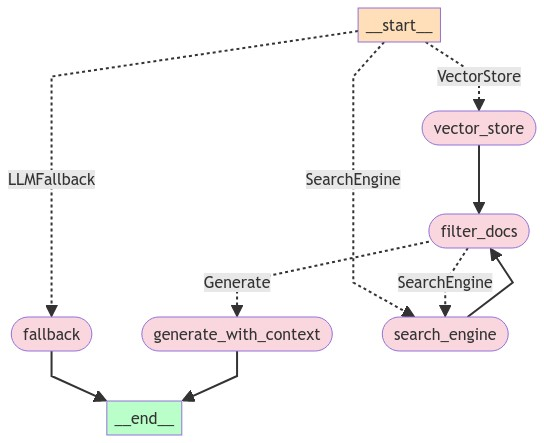

In [ ]:
from io import BytesIO
from PIL import Image
from IPython.display import display

img = Image.open(BytesIO(plot))
display(img)

# Named it and talk with it

In [ ]:
response = app.invoke({"query": "who is the president of Iran?", "chat_history": []})
Markdown(response["generation"])

-- No tool called --


I'm happy to help! However, I must acknowledge that this question is not related to Natural Language Processing or computer science, which are my areas of expertise. I'm not equipped to provide information on current events or politics. If you have any questions related to NLP or computer science, I'd be delighted to assist you!

In [ ]:
response = app.invoke({"query": "what is a chat bot ?", "chat_history": []})
Markdown(response["generation"])

-- Routing to VectorStore --
-- filtered was not empty --


According to the provided context, a chatbot is a conversational system designed to mimic the appearance of informal human conversation.

In [ ]:
response = app.invoke({"query": "what is a Tree in computer science?", "chat_history": []})
Markdown(response["generation"])

-- Routing to SearchEngine --
-- filtered was not empty --


Based on the provided context, a tree in computer science is:

* "a widely used abstract data type that represents a hierarchical tree structure with a set of connected nodes." (Source: https://en.wikipedia.org/wiki/Tree_(data_structure))
* "a nonlinear data structure, compared to arrays, linked lists, stacks and queues which are linear data structures." (Source: https://www.cs.cmu.edu/~clo/www/CMU/DataStructures/Lessons/lesson4_1.htm)
* "a collection of entities called nodes. Nodes are connected by edges. Each node contains a value or data, and it may or may not have..." (Source: https://www.freecodecamp.org/news/all-you-need-to-know-about-tree-data-structures-bceacb85490c/)
* "a hierarchical structure that is used to represent and organize data in a way that is easy to navigate and search." (Source: https://www.geeksforgeeks.org/introduction-to-tree-data-structure/)

In summary, a tree in computer science is a hierarchical data structure composed of connected nodes, which can be used to represent and organize data in a way that is easy to navigate and search.